# Day 7 Amazon Rainforest image segmentation plan and part 1: get imagery 

That is more than 150 acres lost every minute of every day, and 78 million acres lost every year! - source: http://www.rain-tree.com/facts.htm

In August 2017, Brazilian president Michel Temer abolished an Amazonian nature reserve the size of Denmark in Brazil's northern states of Pará and Amapá. - source: https://en.wikipedia.org/wiki/Deforestation_of_the_Amazon_rainforest

Concerns about the policies of Brazil's newly elected president, Jair Bolsonaro. During the 2018 election campaign, Mr Bolsonaro pledged to limit fines for damaging forestry and to weaken the influence of the environmental agency. source: https://www.bbc.co.uk/news/world-latin-america-46327634

Can I show the loss with image segmentation?

1. Get the imagery for 2 seperate years and create an stacked tif
2. Remove noise and smooth imagery
3. Find threshold for forest not forest and try unsupervised image segementation
4. Try supervised image segmentation 
source of tests: https://www.youtube.com/watch?v=pZATswy_IsQ

In [21]:
from sentinelsat import read_geojson, geojson_to_wkt, SentinelAPI
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import os
from osgeo import gdal
import rasterio

### 1. Get the imagery for 2 seperate years and create a stacked tif

Set up data paths and read area of interest (aoi)

In [2]:
datapath = Path('../data/amazon')
list(datapath.rglob('*.geojson'))
aoi = geojson_to_wkt(read_geojson(datapath.joinpath('amapa.geojson')))#; aoi

Set up Copernicus Access Hub username and password variables for api call

In [3]:
username = os.environ.get('COPERNICUS_USERNAME')
password = os.environ.get('COPERNICUS_PASSWORD')
api = SentinelAPI(user=username, password=password)

 Set up parameters for query the api for imagery that is: Sentinel-2, date range and cloud 0-5% 

In [4]:
products = api.query(aoi,
                     date=('20160801', '20161030'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 5))
# date=('20180929', '20180930')

Take the first image of all products returned by the api query and capture the uuid number

In [5]:
product_df = api.to_dataframe(products); print(len(product_df))
uuid = product_df.iloc[0][-1];uuid

1


'1b3b60a4-6677-4dbc-9bc3-2ec5185e0d5a'

Download the imagery

In [6]:
api.download(uuid, datapath)

{'id': '1b3b60a4-6677-4dbc-9bc3-2ec5185e0d5a',
 'title': 'S2A_MSIL1C_20160909T140052_N0204_R067_T22NCG_20160909T140050',
 'size': 814107287,
 'md5': 'FCB55C51D56E7630574A3CBBEF482290',
 'date': datetime.datetime(2016, 9, 9, 14, 0, 52, 26000),
 'footprint': 'POLYGON((-52.79794310916197 1.808922187860351,-51.81097919242989 1.809636200232319,-51.810659142607086 0.816346776559088,-52.797233928576915 0.81602475957957,-52.79794310916197 1.808922187860351))',
 'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('1b3b60a4-6677-4dbc-9bc3-2ec5185e0d5a')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2018, 8, 3, 4, 17, 41, 242000),
 'Ingestion Date': datetime.datetime(2018, 7, 25, 4, 9, 58, 358000),
 'path': '../data/amazon/S2A_MSIL1C_20160909T140052_N0204_R067_T22NCG_20160909T140050.zip',
 'downloaded_bytes': 0}

Unzip the imagery and use gdal to translate jp2000s to tif, then merge the imagery with seperation (stacking) for 4 band tif: RGB and NIR

In [7]:
# ! unzip {datapath}/{product_df.iloc[0][0] + '.zip'} -d {datapath}

In [10]:
# route to jp2s
parts = ['S2A_MSIL1C_20160909T140052_N0204_R067_T22NCG_20160909T140050.SAFE',
         'GRANULE',
         'L1C_T22NCG_A006356_20160909T140050',
         'IMG_DATA']

In [17]:
# translate jp2s to tifs
for i in [2,3,4,8]:
    image_band = 'T22NCG_20160909T140052_B0{}.jp2'.format(i)
    filepath = str(datapath.joinpath(*parts).joinpath(image_band))
    id_image = image_band.split('_')[1]
    mkdir = Path(datapath.joinpath(id_image)).mkdir(parents=True, exist_ok=True)
    datapath2 = datapath.joinpath(id_image)
    out_location = str(datapath2) + '/' + id_image + ('_B0{}'.format(i)) + '.tif'
    src = gdal.Open(filepath)
    gdal.Translate(out_location, src)

In [18]:
# check tifs are there
for i in datapath2.rglob('*.tif'):
    print(i)

../data/amazon/20160909T140052/20160909T140052_B04.tif
../data/amazon/20160909T140052/20160909T140052_B08.tif
../data/amazon/20160909T140052/20160909T140052_B03.tif
../data/amazon/20160909T140052/20160909T140052_B02.tif


In [19]:
# command line call to build a vrt from the tifs
# source: https://stackoverflow.com/questions/52334933/merging-multiple-bands-together-through-gdal-correctly
! gdalbuildvrt -separate {datapath2}/amapa{id_image}.vrt {datapath2}/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
# create a final stacked tif
out_location = str(datapath2) + '/' + 'amapa' + id_image + '.tif'
src = str(datapath2) + '/' +  'amapa' + id_image + '.vrt'
gdal.Translate(out_location, src)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f21cecfd300> >

In [26]:
data_2018 = datapath.joinpath('20180929T140051').joinpath('amapa20180929T140051.tif')
data_2016 = datapath.joinpath('20160909T140052').joinpath('amapa20160909T140052.tif')

In [27]:
image_2018 = rasterio.open(data_2018)
image_2016 = rasterio.open(data_2016)

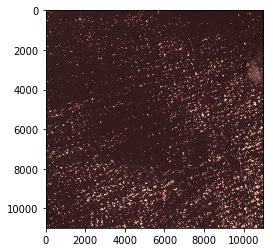

In [39]:
plt.imshow(image_2018.read(1), cmap='pink');